# Northwind Dataset

In [1]:
# import libs
# utility libs
import os
import sys
from pathlib import Path
from dotenv import load_dotenv
# SQL libs
from sqlalchemy import create_engine
# DS DV libs
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# ML libs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC

In [2]:
CURRENT_DIR = Path.cwd()
ROOT_DIR = CURRENT_DIR.parents[2]
# add root dir to sys to use custom packages
sys.path.insert(0, str(ROOT_DIR))

DATA_DIR = os.path.join(ROOT_DIR, 'data')
ENV_DIR = os.path.join(ROOT_DIR, 'env')
SCRIPT_DIR = os.path.join(DATA_DIR, "scripts")
FILES_DIR = os.path.join(DATA_DIR, "files")

load_dotenv(os.path.join(ENV_DIR, ".env"))
SEED = 42
MAX_ITER = 10_000

In [3]:
# import custom libs
import utils.dataviz_utils as custom_viz

[^v^] Seaborn configured with style: 'darkgrid', context: 'notebook'
[°-°] Matplotlib rcParams configured


### 1. Connect to db and query the data

In [ ]:
# load db credentials
DB_CREDS = os.getenv('DB_STRING')
DB_ENGINE = create_engine(DB_CREDS)

In [ ]:
# db query
DB_QUERY = """
SET SCHEMA 'northwind';
SELECT
    -- orders
    ord.orderdate,ord.requireddate, ord.shippeddate, ord.shipvia, ord.freight,
    ord.shipname, ord.shipaddress, ord.shipcity, ord.shipregion,
    ord.shippostalcode, ord.shipcountry,
    -- order details
    odd.unitprice AS order_details_unitprice,
    odd.quantity AS order_details_quantity,
    odd.discount AS order_details_discount,
    -- customers
    cus.companyname AS customers_companyname, 
    cus.contactname AS customers_contactname, 
    cus.contacttitle AS customers_contacttitle, 
    cus.address AS customers_address, 
    cus.city AS customers_city,
    cus.region AS customers_region, 
    cus.postalcode AS customers_postalcode, 
    cus.country AS customers_country, 
    cus.phone AS customers_phone, 
    cus.fax AS customers_fax,
    -- products
    pro.productname,
    pro.quantityperunit AS products_quantity_per_unit,
    pro.unitprice AS products_unitprice,
    pro.unitsinstock AS products_units_in_stock,
    pro.unitsonorder AS products_units_on_order,
    pro.reorderlevel AS products_reorder_level,
    pro.discontinued AS products_discontinued,
    -- categories
    cat.categoryname,
    cat.description AS categories_description,
    cat.picture AS categories_picture,
    -- employees
    emp.lastname AS employees_lastname,
    emp.firstname AS employees_firstname,
    emp.title AS employees_title,
    emp.titleofcourtesy AS employees_title_of_courtesy,
    emp.birthdate AS employees_birthdate,
    emp.hiredate AS employees_hiredate,
    emp.address AS employees_address,
    emp.city AS employees_city, emp.region AS employees_region,
    emp.postalcode AS employees_postalcode,
    emp.country AS employees_country,
    emp.homephone AS employees_homephone,
    emp.extension AS employees_extension,
    emp.photo AS employees_photo,
    emp.notes AS employees_notes,
    emp.reportsto AS employees_reportsto,
    emp.photopath AS employees_photo_path,
    -- employee_territories
    empt.territoryid AS employee_territories_id,
    -- suppliers
    sup.companyname AS suppliers_company_name,
    sup.contactname AS suppliers_contact_name,
    sup.contacttitle AS suppliers_contact_title,
    sup.address AS suppliers_address,
    sup.city AS suppliers_city, sup.region AS suppliers_region,
    sup.postalcode AS suppliers_postalcode,
    sup.country AS suppliers_country,
    sup.phone AS suppliers_phone, sup.fax As suppliers_fax,
    sup.homepage AS suppliers_homepage,
    -- shippers: no relationship found in orders
    -- shi.companyname AS shippers_company_name,
    -- shi.phone AS shippers_phone,
    -- territories
    ter.territorydescription AS territories_description,
    -- regions
    reg.regiondescription AS region_description
FROM orders ord

LEFT JOIN order_details odd ON ord.orderid = odd.orderid
LEFT JOIN customers cus ON ord.customerid = cus.customerid
LEFT JOIN products pro ON odd.productid = pro.productid
LEFT JOIN categories cat ON pro.productid = cat.categoryid
LEFT JOIN employees emp ON ord.employeeid = emp.employeeid
LEFT JOIN employee_territories empt ON emp.employeeid = empt.employeeid
LEFT JOIN suppliers sup ON pro.supplierid = sup.supplierid
-- LEFT JOIN shippers shi ON ord.shipperid = shi.shipperid
LEFT JOIN territories ter ON empt.territoryid = ter.territoryid
LEFT JOIN regions reg ON ter.regionid = reg.regionid;
"""

In [ ]:
# # read data from db
# northwind_dataset = pd.read_sql(DB_QUERY, DB_ENGINE)
# # save to file
# northwind_dataset.to_csv(os.path.join(FILES_DIR, "northwind_dataset.csv"), index=False)

### 2. EDA

In [4]:
northwind_df = pd.read_csv(os.path.join(FILES_DIR, "northwind_dataset.csv"))
northwind_df.head(3)

,orderdate,requireddate,shippeddate,shipvia,freight,shipname,shipaddress,shipcity,shipregion,shippostalcode,...,suppliers_address,suppliers_city,suppliers_region,suppliers_postalcode,suppliers_country,suppliers_phone,suppliers_fax,suppliers_homepage,territories_description,region_description
0,1996-07-04,1996-08-01,1996-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,NaN,51100,...,Calle del Rosal 4,Oviedo,Asturias,33007,Spain,(98) 598 76 54,NaN,NaN,Fairport,Eastern
1,1996-07-04,1996-08-01,1996-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,NaN,51100,...,Calle del Rosal 4,Oviedo,Asturias,33007,Spain,(98) 598 76 54,NaN,NaN,Mellvile,Eastern
2,1996-07-04,1996-08-01,1996-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,NaN,51100,...,Calle del Rosal 4,Oviedo,Asturias,33007,Spain,(98) 598 76 54,NaN,NaN,NewYork,Eastern


In [7]:
# shape: northwind_df.shape -> (10129, 65)
# freight: is fee charge for orders
northwind_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 65 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   orderdate                    10129 non-null  object 
 1   requireddate                 10129 non-null  object 
 2   shippeddate                  9840 non-null   object 
 3   shipvia                      10129 non-null  int64  
 4   freight                      10129 non-null  float64
 5   shipname                     10129 non-null  object 
 6   shipaddress                  10129 non-null  object 
 7   shipcity                     10129 non-null  object 
 8   shipregion                   3864 non-null   object 
 9   shippostalcode               9821 non-null   object 
 10  shipcountry                  10129 non-null  object 
 11  order_details_unitprice      10129 non-null  float64
 12  order_details_quantity       10129 non-null  int64  
 13  order_details_di

In [8]:
# check the percentage of missing data
# more than 90% of data are missing about categories: can be dropped
# suppliers (homepage 65%, region 62%)
# maybe cols where more than 50% of the data are missing can be dropped first
round((northwind_df.isna().mean() * 100).sort_values(ascending=False).head(15), 2)

categoryname              91.86
categories_picture        91.86
categories_description    91.86
suppliers_homepage        75.69
suppliers_region          65.97
customers_region          62.95
shipregion                61.85
suppliers_fax             56.42
employees_region          41.15
customers_fax             31.55
employees_reportsto       16.66
customers_postalcode       3.04
shippostalcode             3.04
shippeddate                2.85
orderdate                  0.00
dtype: float64

In [9]:
northwind_df_00 = northwind_df.copy()

In [10]:
# drop cols with higher pct of missing values and
# some not interesting cols like: phone or photo
northwind_df_00 =  northwind_df_00.drop(columns=[
    "categoryname", "categories_picture", "categories_description",
    "suppliers_homepage", "suppliers_region", "customers_region",
    "shipregion", "suppliers_fax", "customers_fax", "employees_reportsto",
    "suppliers_phone", "employees_photo_path", "employees_notes",
    "employees_photo", "employees_homephone", "customers_phone"
], axis=1)
northwind_df_00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   orderdate                    10129 non-null  object 
 1   requireddate                 10129 non-null  object 
 2   shippeddate                  9840 non-null   object 
 3   shipvia                      10129 non-null  int64  
 4   freight                      10129 non-null  float64
 5   shipname                     10129 non-null  object 
 6   shipaddress                  10129 non-null  object 
 7   shipcity                     10129 non-null  object 
 8   shippostalcode               9821 non-null   object 
 9   shipcountry                  10129 non-null  object 
 10  order_details_unitprice      10129 non-null  float64
 11  order_details_quantity       10129 non-null  int64  
 12  order_details_discount       10129 non-null  float64
 13  customers_compan

In [ ]:
round((northwind_df_00.isna().mean() * 100).sort_values(ascending=False).head(5), 2)

employees_region        41.15
customers_postalcode     3.04
shippostalcode           3.04
shippeddate              2.85
orderdate                0.00
dtype: float64

In [11]:
# are the name of employees or customers etc. relevant for our research questions?
# employees extension: extension of employee's tel nber
# the cols below can be dropped too
northwind_df_00 = northwind_df_00.drop(columns= [
    "order_details_unitprice", "customers_companyname", "customers_contactname",
    "customers_contacttitle", "employees_lastname", "employees_firstname",
    "employees_title", "employees_title_of_courtesy", "employees_extension",
    "employee_territories_id", "suppliers_company_name", "suppliers_contact_name",
    "suppliers_contact_title"
], axis=1)
northwind_df_00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   orderdate                   10129 non-null  object 
 1   requireddate                10129 non-null  object 
 2   shippeddate                 9840 non-null   object 
 3   shipvia                     10129 non-null  int64  
 4   freight                     10129 non-null  float64
 5   shipname                    10129 non-null  object 
 6   shipaddress                 10129 non-null  object 
 7   shipcity                    10129 non-null  object 
 8   shippostalcode              9821 non-null   object 
 9   shipcountry                 10129 non-null  object 
 10  order_details_quantity      10129 non-null  int64  
 11  order_details_discount      10129 non-null  float64
 12  customers_address           10129 non-null  object 
 13  customers_city              101

In [12]:
# are addresses relevant for our research ?
cols_to_drop = [
    "shipaddress", "customers_address", "employees_address", "suppliers_address",
    "shipvia", "shipname"
]
northwind_df_00.loc[:, cols_to_drop].head(3)

,shipaddress,customers_address,employees_address,suppliers_address,shipvia,shipname
0,59 rue de l'Abbaye,59 rue de l'Abbaye,14 Garrett Hill,Calle del Rosal 4,3,Vins et alcools Chevalier
1,59 rue de l'Abbaye,59 rue de l'Abbaye,14 Garrett Hill,Calle del Rosal 4,3,Vins et alcools Chevalier
2,59 rue de l'Abbaye,59 rue de l'Abbaye,14 Garrett Hill,Calle del Rosal 4,3,Vins et alcools Chevalier


In [13]:
northwind_df_00 = northwind_df_00.drop(columns=cols_to_drop, axis=1) # .loc[:, cols_to_drop].head(3)
northwind_df_00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   orderdate                   10129 non-null  object 
 1   requireddate                10129 non-null  object 
 2   shippeddate                 9840 non-null   object 
 3   freight                     10129 non-null  float64
 4   shipcity                    10129 non-null  object 
 5   shippostalcode              9821 non-null   object 
 6   shipcountry                 10129 non-null  object 
 7   order_details_quantity      10129 non-null  int64  
 8   order_details_discount      10129 non-null  float64
 9   customers_city              10129 non-null  object 
 10  customers_postalcode        9821 non-null   object 
 11  customers_country           10129 non-null  object 
 12  productname                 10129 non-null  object 
 13  products_quantity_per_unit  101

In [14]:
# let start convert date and continue to observe the data
date_type_cols = ["orderdate", "requireddate", "shippeddate", "employees_birthdate", "employees_hiredate"]
for col in date_type_cols:
    northwind_df_00[col] = pd.to_datetime(
        northwind_df_00[col], yearfirst=True,
        errors="coerce" # convert error to Not a Time
    )
northwind_df_00[date_type_cols].dtypes

orderdate              datetime64[ns]
requireddate           datetime64[ns]
shippeddate            datetime64[ns]
employees_birthdate    datetime64[ns]
employees_hiredate     datetime64[ns]
dtype: object

In [ ]:
northwind_df_00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   orderdate                   10129 non-null  datetime64[ns]
 1   requireddate                10129 non-null  datetime64[ns]
 2   shippeddate                 9840 non-null   datetime64[ns]
 3   freight                     10129 non-null  float64       
 4   shipcity                    10129 non-null  object        
 5   shippostalcode              9821 non-null   object        
 6   shipcountry                 10129 non-null  object        
 7   order_details_quantity      10129 non-null  int64         
 8   order_details_discount      10129 non-null  float64       
 9   customers_city              10129 non-null  object        
 10  customers_postalcode        9821 non-null   object        
 11  customers_country           10129 non-null  object    

In [ ]:
round((northwind_df_00.isna().mean() * 100).sort_values(ascending=False), 2)

employees_region              41.15
shippostalcode                 3.04
customers_postalcode           3.04
shippeddate                    2.85
freight                        0.00
requireddate                   0.00
shipcity                       0.00
shipcountry                    0.00
order_details_discount         0.00
order_details_quantity         0.00
customers_city                 0.00
customers_country              0.00
productname                    0.00
orderdate                      0.00
products_quantity_per_unit     0.00
products_unitprice             0.00
products_units_on_order        0.00
products_units_in_stock        0.00
products_discountinued         0.00
employees_birthdate            0.00
employees_hiredate             0.00
products_reorder_level         0.00
employees_city                 0.00
employees_postalcode           0.00
employees_country              0.00
suppliers_city                 0.00
suppliers_postalcode           0.00
suppliers_country           

In [15]:
# check unique values excluding date
northwind_df_00.drop(columns=date_type_cols).nunique()

freight                       799
shipcity                       70
shippostalcode                 84
shipcountry                    21
order_details_quantity         55
order_details_discount         11
customers_city                 70
customers_postalcode           84
customers_country              21
productname                    77
products_quantity_per_unit     70
products_unitprice             62
products_units_in_stock        51
products_units_on_order        10
products_reorder_level          7
products_discontinued           2
employees_city                  5
employees_region                1
employees_postalcode            9
employees_country               2
suppliers_city                 29
suppliers_postalcode           29
suppliers_country              16
territories_description        48
region_description              4
dtype: int64

<Axes: >

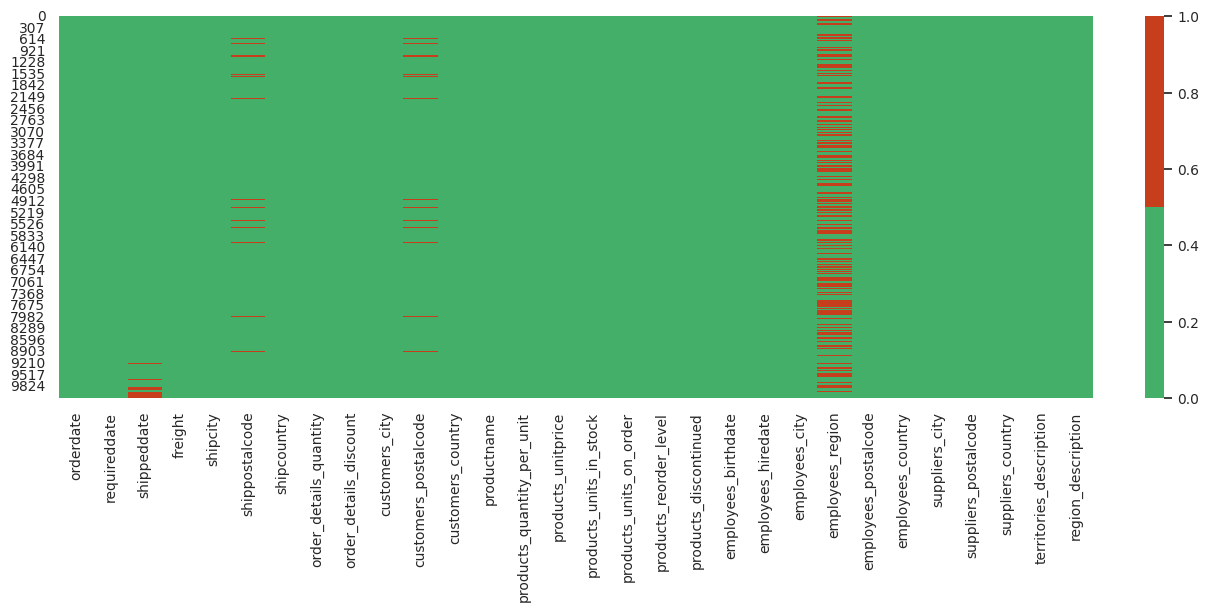

In [ ]:
sns.heatmap(northwind_df_00.isna(), cmap=custom_viz.MIXED_PALETTE[:2])

In [16]:
last_na_cols_to_drop = ["shippeddate", "shippostalcode", "customers_postalcode", "employees_region"]
northwind_df_00 = northwind_df_00.drop(columns=last_na_cols_to_drop, axis=1)
northwind_df_00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   orderdate                   10129 non-null  datetime64[ns]
 1   requireddate                10129 non-null  datetime64[ns]
 2   freight                     10129 non-null  float64       
 3   shipcity                    10129 non-null  object        
 4   shipcountry                 10129 non-null  object        
 5   order_details_quantity      10129 non-null  int64         
 6   order_details_discount      10129 non-null  float64       
 7   customers_city              10129 non-null  object        
 8   customers_country           10129 non-null  object        
 9   productname                 10129 non-null  object        
 10  products_quantity_per_unit  10129 non-null  object        
 11  products_unitprice          10129 non-null  float64   

In [ ]:
# check null values on cols
northwind_df_00.isna().sum()

orderdate                     0
requireddate                  0
freight                       0
shipcity                      0
shipcountry                   0
order_details_quantity        0
order_details_discount        0
customers_city                0
customers_country             0
productname                   0
products_quantity_per_unit    0
products_unitprice            0
products_units_in_stock       0
products_units_on_order       0
products_reorder_level        0
products_discontinued         0
employees_birthdate           0
employees_hiredate            0
employees_city                0
employees_postalcode          0
employees_country             0
suppliers_city                0
suppliers_postalcode          0
suppliers_country             0
territories_description       0
region_description            0
dtype: int64

In [ ]:
# is there null on any row?
northwind_df_00[northwind_df_00.isna().any(axis=1)]

,orderdate,requireddate,freight,shipcity,shipcountry,order_details_quantity,order_details_discount,customers_city,customers_country,productname,...,employees_birthdate,employees_hiredate,employees_city,employees_postalcode,employees_country,suppliers_city,suppliers_postalcode,suppliers_country,territories_description,region_description


In [ ]:
# numeric cols
northwind_df_00.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
orderdate,10129,1997-08-09 00:08:14.737881344,1996-07-04 00:00:00,1997-02-28 00:00:00,1997-09-05 00:00:00,1998-02-04 00:00:00,1998-05-06 00:00:00,NaN
requireddate,10129,1997-09-06 02:15:37.585151488,1996-07-24 00:00:00,1997-03-31 00:00:00,1997-10-07 00:00:00,1998-03-05 00:00:00,1998-06-11 00:00:00,NaN
freight,10129.0,101.391841,0.02,19.64,55.12,123.83,1007.64,142.631067
order_details_quantity,10129.0,24.343963,1.0,10.0,20.0,30.0,130.0,19.410689
order_details_discount,10129.0,0.058074,0.0,0.0,0.0,0.1,0.25,0.084065
products_unitprice,10129.0,28.177478,2.5,12.5,19.45,34.0,263.5,32.381825
products_units_in_stock,10129.0,39.567085,0.0,17.0,25.0,57.0,125.0,36.098826
products_units_on_order,10129.0,8.161714,0.0,0.0,0.0,0.0,100.0,19.840824
products_reorder_level,10129.0,11.786455,0.0,0.0,10.0,20.0,30.0,10.761393
employees_birthdate,10129,1955-11-05 08:59:31.211373312,1937-09-19 00:00:00,1952-02-19 00:00:00,1958-01-09 00:00:00,1963-07-02 00:00:00,1966-01-27 00:00:00,NaN


/home/rackkoun/Documents/Workspaces/neuefishe/projects/learnings/.learnenv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


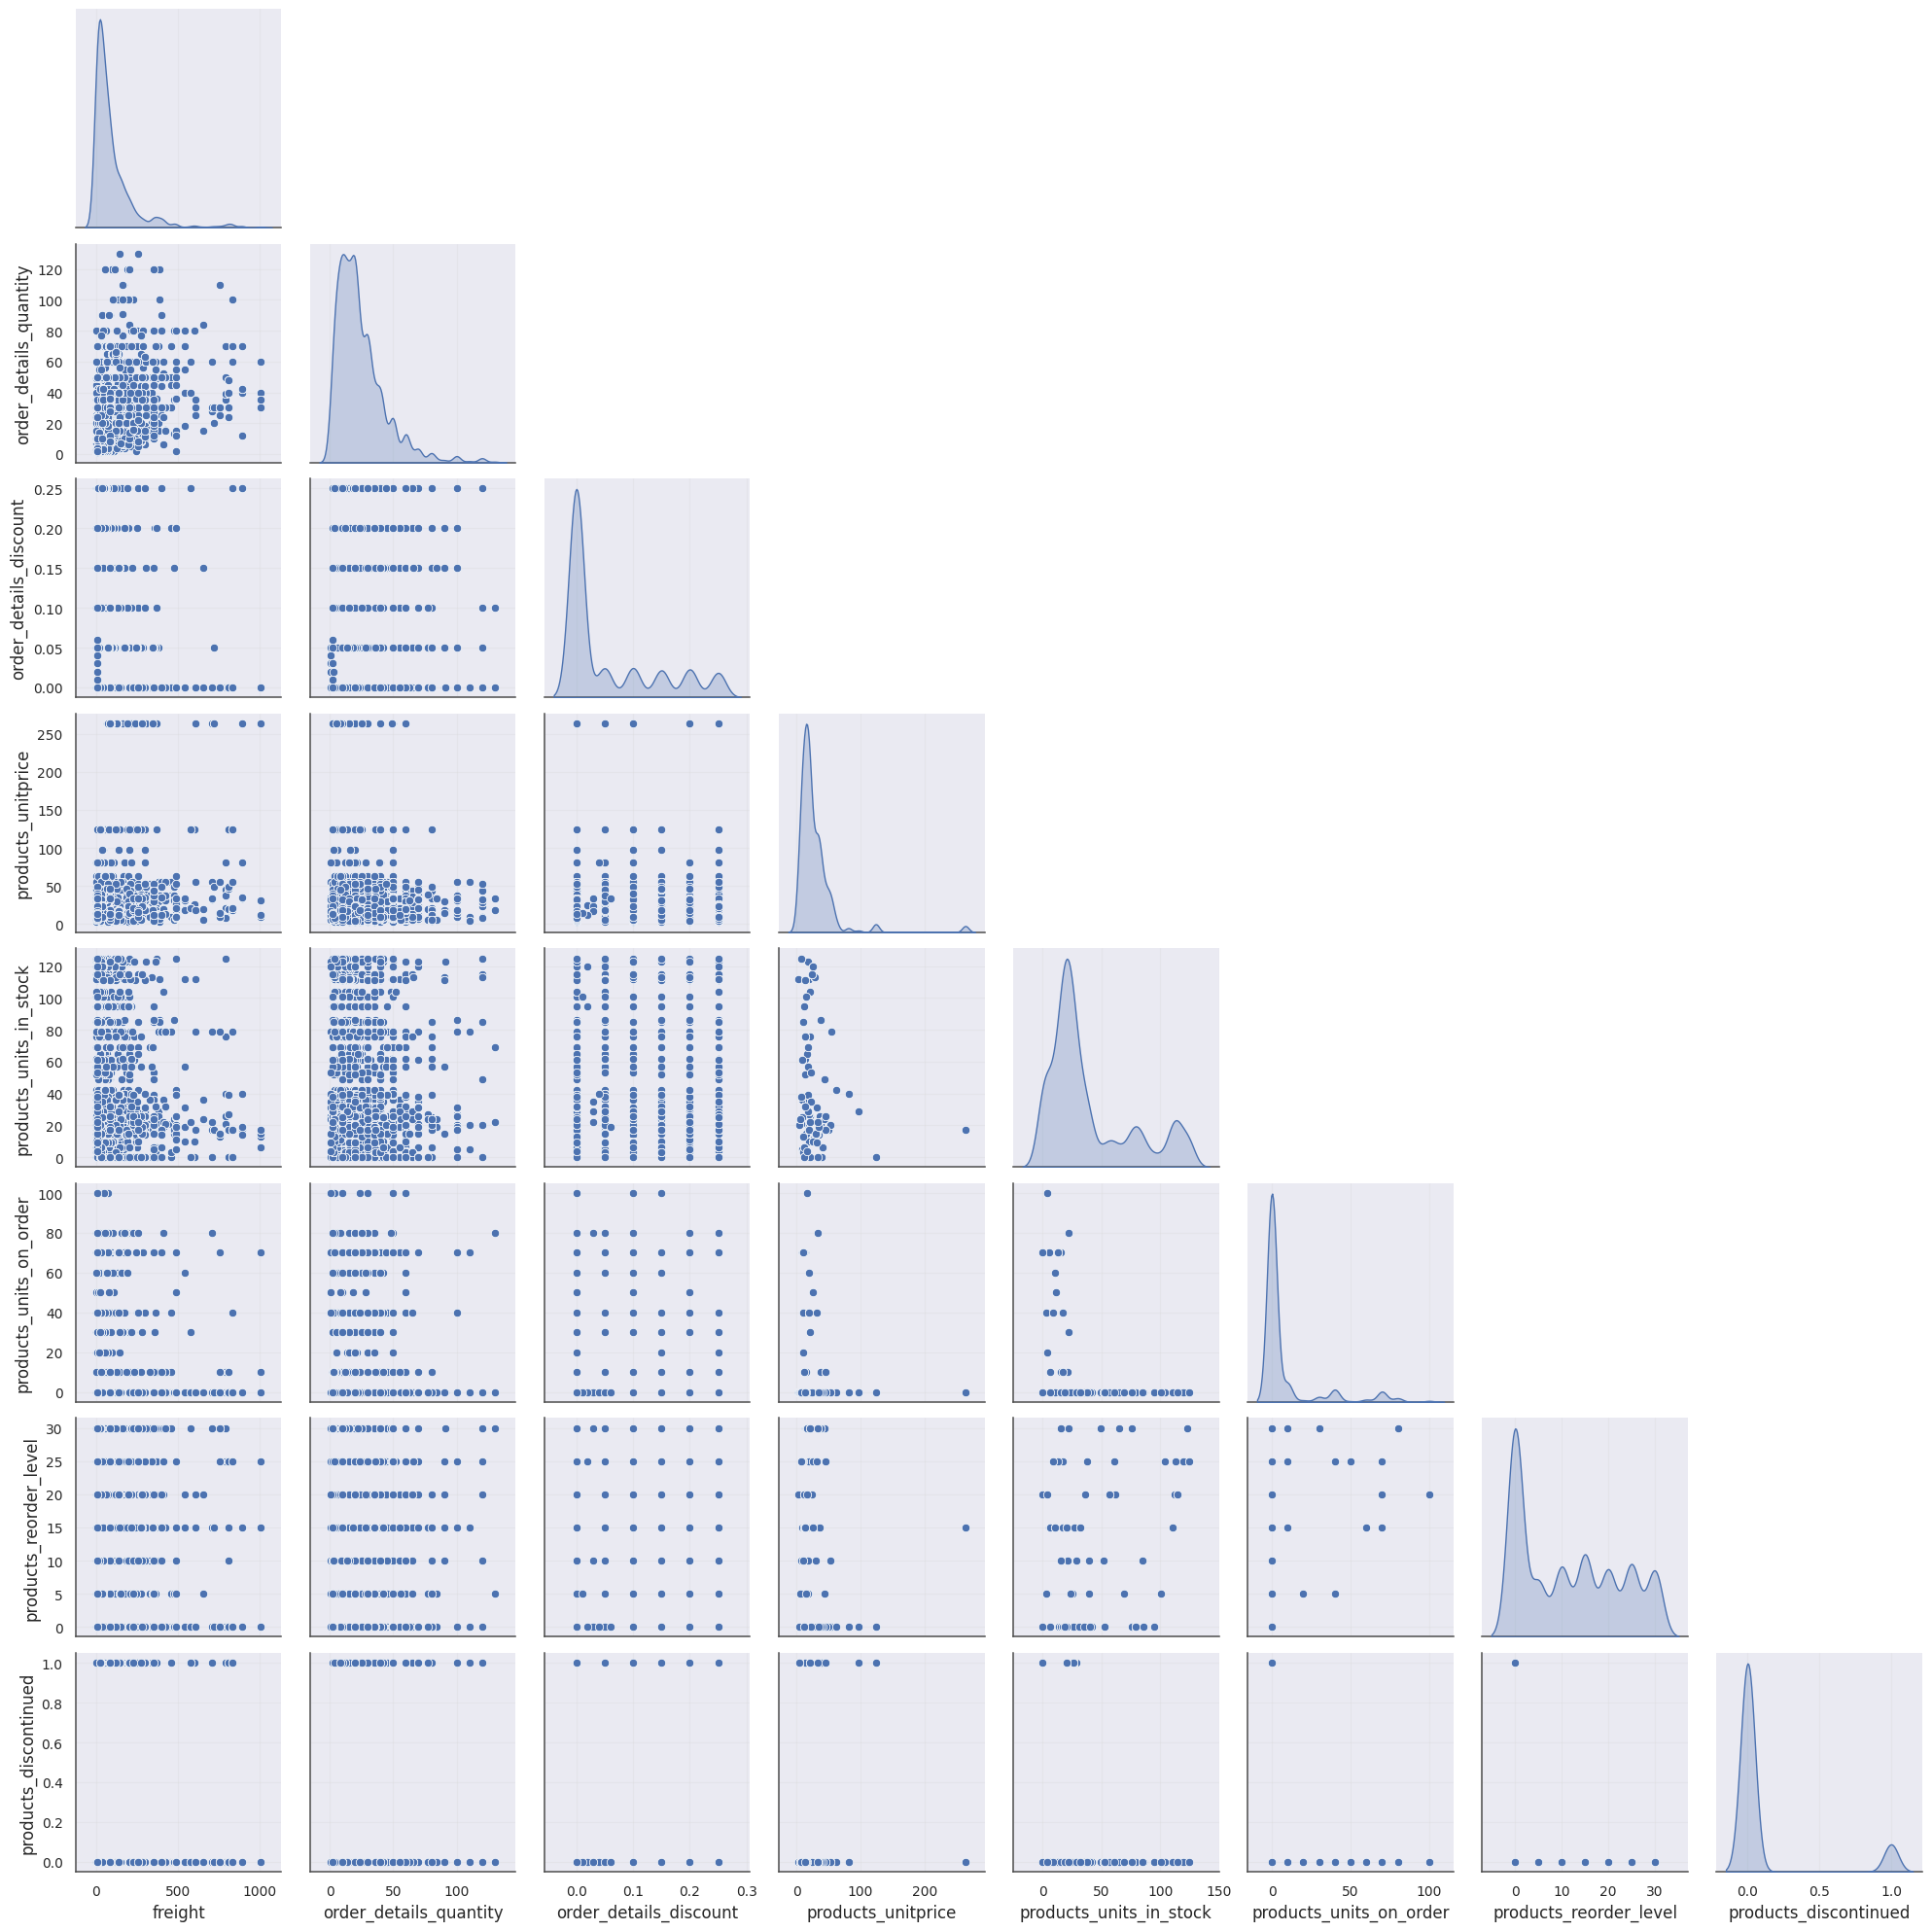

In [13]:
sns.pairplot(
    northwind_df_00,
    diag_kind="kde",
    corner=True
)
plt.tight_layout()
plt.show()

In [ ]:
northwind_df_00.nunique()

orderdate                     480
requireddate                  454
freight                       799
shipcity                       70
shipcountry                    21
order_details_quantity         55
order_details_discount         11
customers_city                 70
customers_country              21
productname                    77
products_quantity_per_unit     70
products_unitprice             62
products_units_in_stock        51
products_units_on_order        10
products_reorder_level          7
products_discontinued           2
employees_birthdate             9
employees_hiredate              8
employees_city                  5
employees_postalcode            9
employees_country               2
suppliers_city                 29
suppliers_postalcode           29
suppliers_country              16
territories_description        48
region_description              4
dtype: int64

In [17]:
# since I have less exp in time series manipulation and dates, let remove completely all dates cols
# 
cols_to_drop = ["orderdate", "requireddate", "employees_birthdate", "employees_hiredate"]

In [18]:
northwind_df_00 = northwind_df_00.drop(columns=cols_to_drop, axis=1)
northwind_df_00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   freight                     10129 non-null  float64
 1   shipcity                    10129 non-null  object 
 2   shipcountry                 10129 non-null  object 
 3   order_details_quantity      10129 non-null  int64  
 4   order_details_discount      10129 non-null  float64
 5   customers_city              10129 non-null  object 
 6   customers_country           10129 non-null  object 
 7   productname                 10129 non-null  object 
 8   products_quantity_per_unit  10129 non-null  object 
 9   products_unitprice          10129 non-null  float64
 10  products_units_in_stock     10129 non-null  int64  
 11  products_units_on_order     10129 non-null  int64  
 12  products_reorder_level      10129 non-null  int64  
 13  products_discontinued       101

/tmp/ipykernel_187076/1786807671.py:1: UserWarning: 
The palette list has fewer values (16) than needed (21) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(
/tmp/ipykernel_187076/1786807671.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


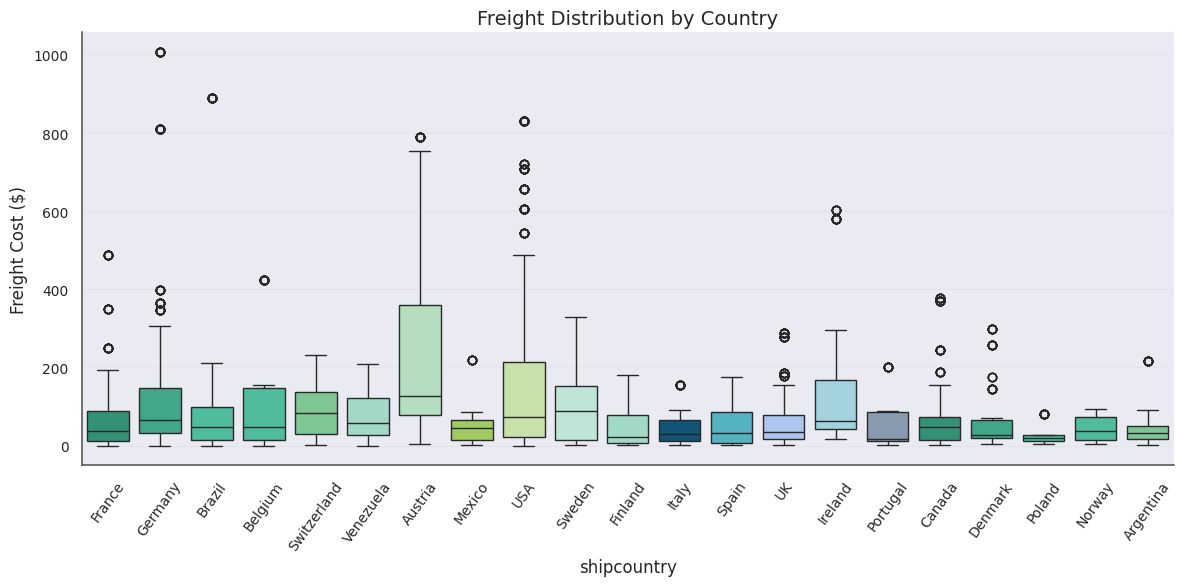

In [ ]:
sns.boxplot(
    data=northwind_df_00,
    x="shipcountry", y="freight",
    palette=custom_viz.PALETTE_BLUE_GREEN[: len(northwind_df_00["shipcountry"].unique())],
    hue="shipcountry"
)
plt.title("Freight Distribution by Country")
plt.xticks(rotation=54)
plt.ylabel("Freight Cost ($)")
plt.tight_layout()
plt.show()

In [19]:
top_products = northwind_df_00.groupby("productname", as_index=False)["freight"].agg(["median", "mean", "std"])

top_products.sort_values(by=["mean"], ascending=False)

,productname,median,mean,std
11,Côte de Blaye,280.61,330.697167,262.499564
68,Thüringer Rostbratwurst,138.37,242.399487,251.953101
1,Aniseed Syrup,64.45,235.156226,328.959252
61,Sir Rodney's Marmalade,98.03,212.135190,270.115365
9,Chef Anton's Gumbo Mix,48.29,176.348871,290.405633
...,...,...,...,...
10,Chocolade,47.45,50.352692,41.483791
12,Escargots de Bourgogne,31.85,49.908026,55.460814
35,Louisiana Hot Spiced Okra,48.07,46.946500,24.913349
33,Longlife Tofu,22.98,44.310968,45.267370


In [20]:
avg_freight_by_country = northwind_df_00.groupby("shipcountry", as_index=False)["freight"].mean()
avg_freight_by_country

,shipcountry,freight
0,Argentina,48.584205
1,Austria,225.997663
2,Belgium,87.176049
3,Brazil,83.129858
4,Canada,82.742023
5,Denmark,65.931943
6,Finland,51.208763
7,France,60.527282
8,Germany,120.688141
9,Ireland,131.522500


In [21]:
order_details_discount_grouped = northwind_df_00.groupby(
    ["order_details_discount", "products_discontinued"]).agg(
        order_count=("freight", "count"),
        avg_freight=("freight", "mean")
    ).reset_index()
order_details_discount_grouped.sort_values(by="products_discontinued")

,order_details_discount,products_discontinued,order_count,avg_freight
0,0.00,False,5379,96.956977
13,0.20,False,736,96.455774
11,0.15,False,730,105.297808
9,0.10,False,746,79.429155
15,0.25,False,610,155.621098
6,0.05,False,737,108.432551
8,0.06,False,2,8.530000
4,0.03,False,6,8.530000
3,0.02,False,4,8.530000
2,0.01,False,2,8.530000


/tmp/ipykernel_10272/189440873.py:64: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


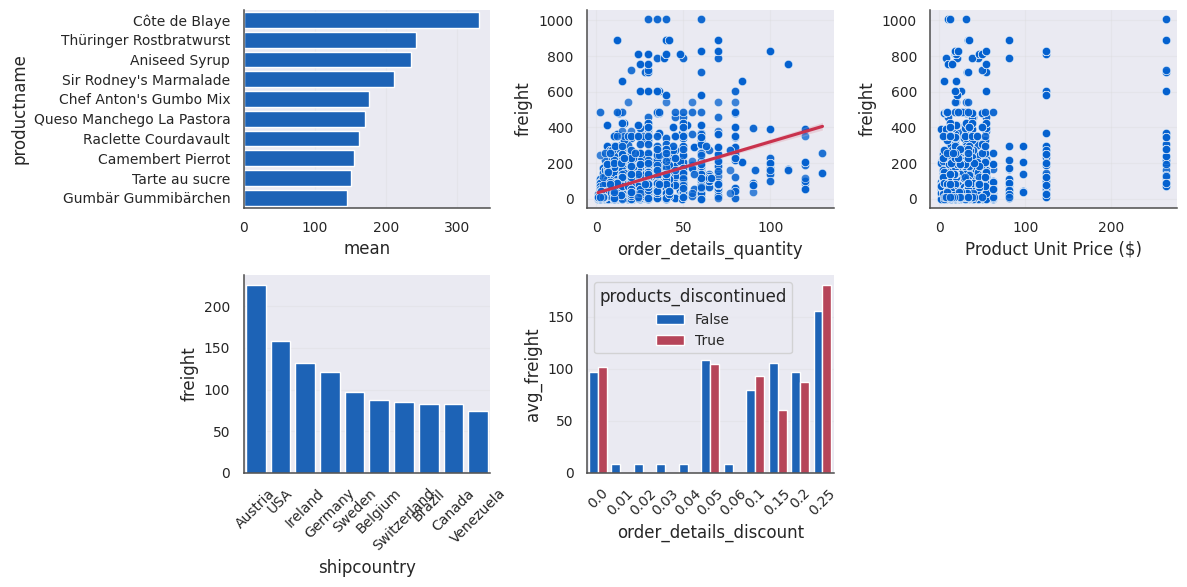

In [22]:
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
# productname by freight - 1
sns.barplot(
    data=top_products.sort_values(by=["mean"], ascending=False).head(10),
    x="mean", y="productname", ax=axes[0],
    color=custom_viz.PALETTE_BLUE[4]
)
# order qtity by freight - 2
sns.scatterplot(
    data=northwind_df_00,
    x="order_details_quantity",
    y="freight",
    ax=axes[1],
    color=custom_viz.PALETTE_BLUE[4],
    alpha=0.5
)
# add regplot to plot #2
sns.regplot(
    data=northwind_df_00,
    x="order_details_quantity",
    y="freight",
    scatter=False,
    color=custom_viz.PALETTE_RED[4],
    ax=axes[1]
)
# product unit price vs freight
sns.scatterplot(
    data=northwind_df_00,
    x="products_unitprice",
    y="freight",
    alpha=0.6,
    color=custom_viz.PALETTE_BLUE[4],
    ax=axes[2]
)
axes[2].set_xlabel("Product Unit Price ($)")
# avg freight by country - 3
sns.barplot(
    data=avg_freight_by_country.sort_values(by=["freight"], ascending=False).head(10),
    x="shipcountry",
    y="freight",
    ax=axes[3],
    color=custom_viz.PALETTE_BLUE[4]
)
axes[3].tick_params(axis="x", labelrotation=45)
# freight vs discount - 4
sns.barplot(
    data=order_details_discount_grouped.sort_values(by="products_discontinued", ascending=False),
    x="order_details_discount",
    y="avg_freight",
    ax=axes[4],
    hue="products_discontinued",
    palette={
        False: custom_viz.PALETTE_BLUE[4],
        True: custom_viz.PALETTE_RED[4]
    }
)

# legend
# sns.move_legend(axes[4], "lower left", bbox_to_anchor=(1.05, 0.5))
axes[4].tick_params(axis="x", labelrotation=45)
# delete axes 5
axes[5].remove()
plt.tight_layout()
# plt.legend(bbox_to_anchor=(1.05, 1), loc="lower right")
plt.show()

In [23]:
discontinued_products = northwind_df_00["products_discontinued"].value_counts()
discontinued_products

products_discontinued
False    8954
True     1175
Name: count, dtype: int64

In [24]:
discontinued_products_df = pd.DataFrame(
    columns=[
        "Discontinued",
        "Values"
    ],
    data=[
        [discontinued_products.index[0],
        discontinued_products.values[0]
        ],

        [discontinued_products.index[1],
        discontinued_products.values[1]]
    ]
)
discontinued_products_df

,Discontinued,Values
0,False,8954
1,True,1175


In [25]:
discontinued_products_by_region = northwind_df_00.groupby("shipcountry", as_index=False).agg(
    avg_discontinued=("products_discontinued", "mean")
)
discontinued_products_by_region.head(3)

,shipcountry,avg_discontinued
0,Argentina,0.113636
1,Austria,0.136223
2,Belgium,0.138889


In [26]:
discontinued_product_by_unitprice_and_name = northwind_df_00.groupby(
    ["products_unitprice", "productname"]
).agg(
    avg_discontinued=("products_discontinued", "mean")
).reset_index()
discontinued_product_by_unitprice_and_name

,products_unitprice,productname,avg_discontinued
0,2.50,Geitost,0.0
1,4.50,Guaraná Fantástica,1.0
2,6.00,Konbu,0.0
3,7.00,Filo Mix,0.0
4,7.45,Tourtière,0.0
...,...,...,...
72,62.50,Carnarvon Tigers,0.0
73,81.00,Sir Rodney's Marmalade,0.0
74,97.00,Mishi Kobe Niku,1.0
75,123.79,Thüringer Rostbratwurst,1.0


/tmp/ipykernel_10272/759629467.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3].set_xticklabels(["Active", "Discontinued"])
/tmp/ipykernel_10272/759629467.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[4].set_xticklabels(["Active", "Discontinued"])
/tmp/ipykernel_10272/759629467.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[5].set_xticklabels(["Active", "Discontinued"])
/tmp/ipykernel_10272/759629467.py:92: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


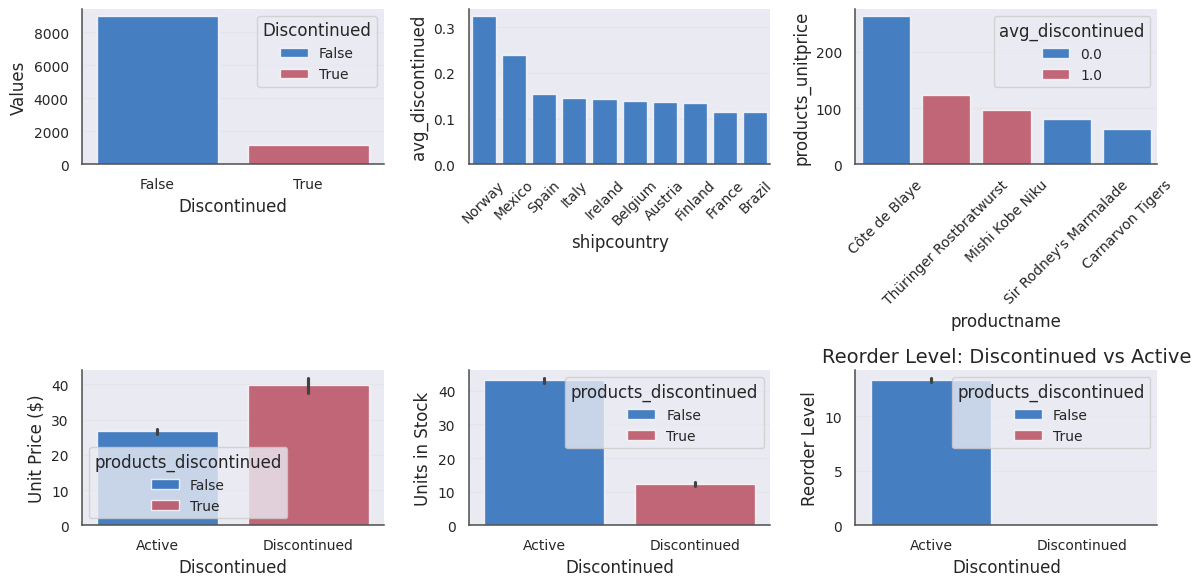

In [27]:
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
# discontinued vs not distribution - #1
sns.barplot(
    data=discontinued_products_df,
    x="Discontinued",
    y="Values",
    ax=axes[0],
    hue="Discontinued",
    palette={
        True: custom_viz.PALETTE_RED[4],
        False: custom_viz.PALETTE_BLUE[4]
    },
    alpha=0.8
)
# avg discontinued products by region -#2
sns.barplot(
    data=discontinued_products_by_region.sort_values(by="avg_discontinued", ascending=False).head(10),
    x="shipcountry",
    y="avg_discontinued",
    color=custom_viz.PALETTE_BLUE[4],
    alpha=0.8,
    ax=axes[1]
)
axes[1].tick_params(axis="x", labelrotation=45)

# product unit price discontinued
sns.barplot(
    data=discontinued_product_by_unitprice_and_name.sort_values(
        by="products_unitprice", ascending=False
    ).head(5),
    x="productname",
    y="products_unitprice",
    hue="avg_discontinued",
    ax=axes[2],
    palette={
        0.0: custom_viz.PALETTE_BLUE[4],
        1.0: custom_viz.PALETTE_RED[4]
    },
    alpha=0.8
)
axes[2].tick_params(axis="x", labelrotation=45)
# Disontinued vs unit price
sns.barplot(
    data=northwind_df_00,
    x="products_discontinued",
    y="products_unitprice",
    ax=axes[3],
    hue="products_discontinued",
    palette={
        True: custom_viz.PALETTE_RED[4],
        False: custom_viz.PALETTE_BLUE[4]
    },
    alpha=0.8
)
axes[3].set_xlabel("Discontinued")
axes[3].set_ylabel("Unit Price ($)")
axes[3].set_xticklabels(["Active", "Discontinued"])
# discontinued by units in stock
sns.barplot(
    data=northwind_df_00,
    x="products_discontinued",
    y="products_units_in_stock",
    ax=axes[4],
    alpha=0.8,
    hue="products_discontinued",
    palette={
        False: custom_viz.PALETTE_BLUE[4],
        True: custom_viz.PALETTE_RED[4]
    }
)
axes[4].set_ylabel("Units in Stock")
axes[4].set_xlabel("Discontinued")
axes[4].set_xticklabels(["Active", "Discontinued"])
# discontinued by reorder level
sns.barplot(
    data=northwind_df_00,
    x="products_discontinued",
    y="products_reorder_level",
    ax=axes[5],
    hue="products_discontinued",
    palette={
        False: custom_viz.PALETTE_BLUE[4],
        True: custom_viz.PALETTE_RED[4]
    },
    alpha=0.8
)
axes[5].set_xlabel("Discontinued")
axes[5].set_ylabel("Reorder Level")
axes[5].set_title("Reorder Level: Discontinued vs Active")
axes[5].set_xticklabels(["Active", "Discontinued"])
plt.tight_layout()
plt.show()

/tmp/ipykernel_10272/410921966.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


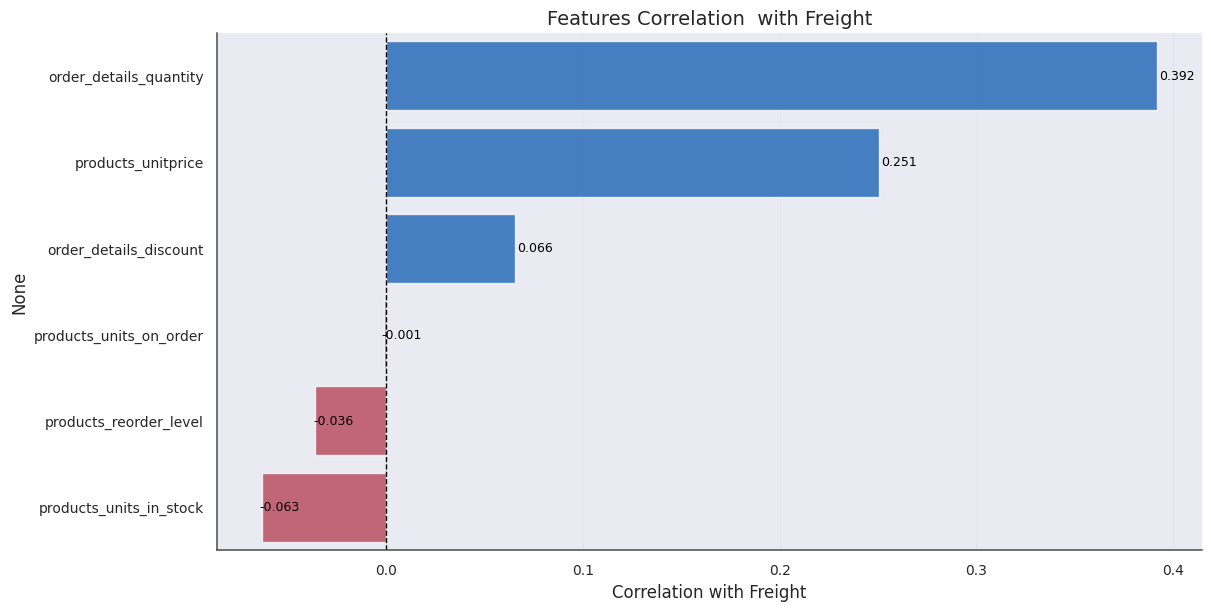

In [28]:
# Correlation Matrices
numericals_cols = northwind_df_00.select_dtypes(include=[np.number]).columns.tolist()
numericals_cols = [col for col in numericals_cols if col != "freight"]
# correlation with freihgt
freight_corr = northwind_df_00[numericals_cols + ["freight"]].corr()["freight"].drop("freight").sort_values(
    ascending=False
)
colors = [custom_viz.PALETTE_RED[4] if x < 0 else custom_viz.PALETTE_BLUE[4] for x in freight_corr.values]
# plot corr
sns.barplot(
    x=freight_corr.values,
    y=freight_corr.index,
    palette=colors,
    alpha=0.8
)
plt.axvline(
    x=0,
    color="black",
    linestyle="--",
    linewidth=1
)
# add annotation
for idx, val in enumerate(freight_corr.values):
    plt.text(
        val + (0.001 if val>=0 else -0.001), idx, f"{val:.3f}",
        va="center", fontsize=9,
        color="black"
    )
plt.xlabel("Correlation with Freight")
plt.title("Features Correlation  with Freight")
plt.show()

/tmp/ipykernel_10272/563454617.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


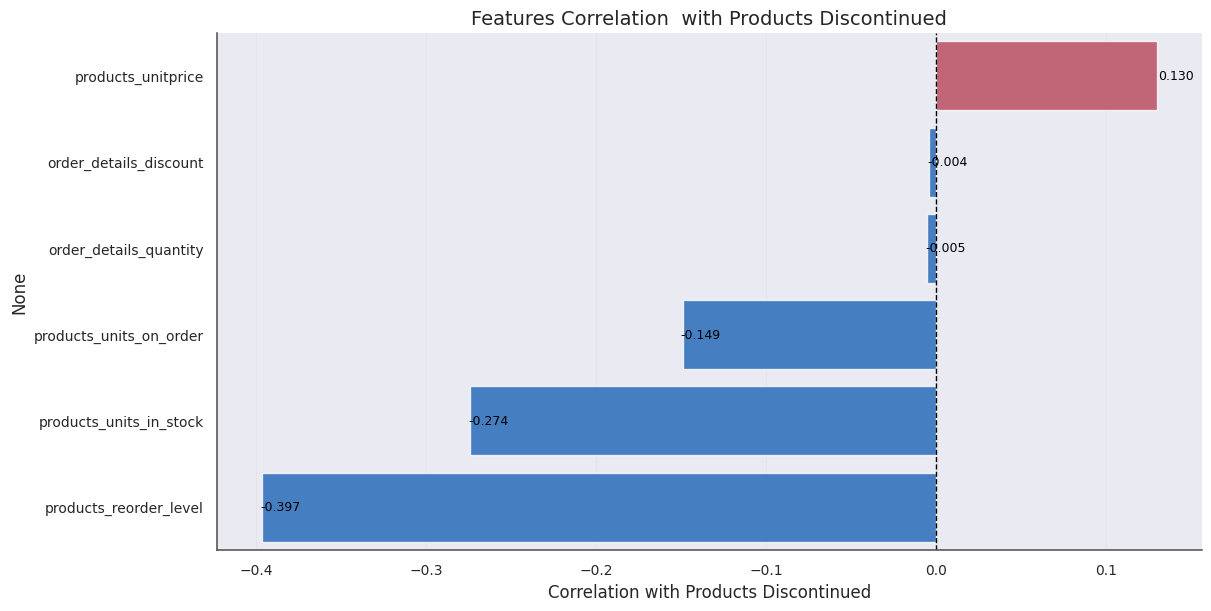

In [29]:
# discontinued correlation
discontinued_corr = northwind_df_00[numericals_cols + ["products_discontinued"]].corr()[
    "products_discontinued"
].drop("products_discontinued").sort_values(ascending=False)
colors = [custom_viz.PALETTE_RED[4] if x > 0 else custom_viz.PALETTE_BLUE[4] for x in discontinued_corr.values]
# plot corr
sns.barplot(
    x=discontinued_corr.values,
    y=discontinued_corr.index,
    palette=colors,
    alpha=0.8
)
plt.axvline(
    x=0,
    color="black",
    linestyle="--",
    linewidth=1
)
# add annotation
for idx, val in enumerate(discontinued_corr.values):
    plt.text(
        val + (0.001 if val>=0 else -0.001), idx, f"{val:.3f}",
        va="center", fontsize=9,
        color="black"
    )
plt.xlabel("Correlation with Products Discontinued")
plt.title("Features Correlation  with Products Discontinued")
plt.show()

### 3. ML

In [30]:
# feature selection
freight_features = [
    "products_unitprice", "order_details_quantity", "order_details_discount",
    "productname", "shipcountry"
]
discontinued_features = [
    "products_unitprice", "products_units_in_stock", "products_reorder_level",
    "productname", "shipcountry"
]
# prepare the data
# freight
X_freight = northwind_df_00[freight_features]
y_freight = northwind_df_00["freight"]
# products discontinued
X_discontinued = northwind_df_00[discontinued_features]
y_discontinued = northwind_df_00["products_discontinued"].astype(int)

# split data
X_train_freight, X_test_freight, y_train_freight, y_test_freight = train_test_split(
    X_freight, y_freight, test_size=0.2, random_state=SEED
)
X_train_discontinued, X_test_discontinued, y_train_discontinued, y_test_discontinued = train_test_split(
    X_discontinued, y_discontinued, test_size=0.2, random_state=SEED, stratify=y_discontinued
)

In [31]:
# models pipeline
models_pipeline = {
    # regression pipeline - freight
    "rfr": Pipeline([
        ("preprocessor", ColumnTransformer([
            ("num", StandardScaler(), freight_features[:3]),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), freight_features[3:])
        ])),
        ("estimator", RandomForestRegressor(random_state=SEED, max_depth=5))
    ]),
    "ridge": Pipeline([
        ("preprocessor", ColumnTransformer([
            ("num", StandardScaler(), freight_features[:3]),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), freight_features[3:])
        ])),
        ("estimator", Ridge(random_state=SEED, max_iter=MAX_ITER))
    ]),
    "lasso": Pipeline([
        ("preprocessor", ColumnTransformer([
            ("num", StandardScaler(), freight_features[:3]),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), freight_features[3:])
        ])),
        ("estimator", Lasso(random_state=SEED,max_iter=MAX_ITER))
    ]),
    # classification
    "logreg": Pipeline([
        ("preprocessor", ColumnTransformer([
            ("num", StandardScaler(), discontinued_features[:3]),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), discontinued_features[3:])
        ])),
        ("estimator", LogisticRegression(random_state=SEED, max_iter=MAX_ITER, C=0.1))
    ]),
    "svc": Pipeline([
        ("preprocessor", ColumnTransformer([
            ("num", StandardScaler(), discontinued_features[:3]),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), discontinued_features[3:])
        ])),
        ("estimator", SVC(random_state=SEED, max_iter=MAX_ITER, C=0.1, kernel="linear"))
    ]),
    "rfc": Pipeline([
        ("preprocessor", ColumnTransformer([
            ("num", StandardScaler(), discontinued_features[:3]),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), discontinued_features[3:])
        ])),
        ("estimator", RandomForestClassifier(random_state=SEED, max_depth=5, max_features="sqrt"))
    ])
}
# model params for grid search
models_params = {
    # freight
    "rfr": {"estimator__n_estimators": [50, 100], "estimator__max_depth": [3, 5, 7]},
    "ridge": {"estimator__alpha": [0.1, 1.0, 10.0, 100]},
    "lasso": {"estimator__alpha": [0.01, 0.1, 1.0, 10.0]},
    # products discontinued
    "logreg": {"estimator__C":[0.01, 0.1, 1], "estimator__penalty": ["l2"]},
    "svc": {"estimator__C": [0.01, 0.1, 1], "estimator__kernel": ["linear", "rbf"]},
    "rfc": {"estimator__n_estimators": [50, 100], "estimator__max_depth": [3, 5, 7]}
}

In [32]:
# save results for later insight
results = []
best_models = {}
conf_matrices = {}

In [33]:
for model_name in ["ridge", "lasso", "rfr", "logreg", "svc", "rfc"]:
    task = "reg" if model_name in ["ridge", "lasso", "rfr"] else "clf"

    if task=="reg":
        X_train, X_test, y_train, y_test = X_train_freight, X_test_freight, y_train_freight, y_test_freight
    else:
        X_train, X_test, y_train, y_test = X_train_discontinued, X_test_discontinued, y_train_discontinued, y_test_discontinued
    # grid search
    print(f"{'='*60}")
    print(f"Training {model_name} ({'Regression' if task=='reg' else 'Classification'})")
    print(f"{'='*60}")

    grid = GridSearchCV(
        models_pipeline[model_name],
        models_params[model_name],
        cv=5,
        scoring='r2' if task=="reg" else "f1_weighted",
        n_jobs=-1,
        verbose=1
    )
    # train
    grid.fit(X_train, y_train)
    best_models[model_name] = grid.best_estimator_
    # predict
    y_pred_train = grid.predict(X_train)
    y_pred_test = grid.predict(X_test)
    # evaluate
    if task=="reg":
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        # append results
        results.append({
            "model": model_name, "task": "regression",
            "train_r2": train_r2, "test_r2": test_r2,
            "train_rmse": train_rmse, "test_rmse": test_rmse,
            "best_params": grid.best_params_,
            "cv_score": grid.best_score_
        })
        print(f"Best params: {grid.best_params_}")
        print(f"CV Score (R²): {grid.best_score_:.4f}")
        print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
        print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
        print(f"Overfitting: {'YES' if train_r2 - test_r2 > 0.15 else 'NO'}")
    # classification
    else:
        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)
        conf_matrix = confusion_matrix(y_test, y_pred_test)
        conf_matrices[model_name] = conf_matrix
        # append results
        results.append({
            "model": model_name, "task": "classification",
            "train_acc": train_acc, "test_acc": test_acc,
            "precision": classification_report(y_test, y_pred_test, output_dict=True)['weighted avg']['precision'],
            "recall": classification_report(y_test, y_pred_test, output_dict=True)['weighted avg']['recall'],
            "f1": classification_report(y_test, y_pred_test, output_dict=True)['weighted avg']['f1-score'],
            "best_params": str(grid.best_params_),
            "cv_score": grid.best_score_
        })
        
        print(f"Best params: {grid.best_params_}")
        print(f"CV Score (F1): {grid.best_score_:.4f}")
        print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
        print(f"Overfitting: {'YES' if train_acc - test_acc > 0.15 else 'NO'}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_test))

Training ridge (Regression)
Fitting 5 folds for each of 4 candidates, totalling 20 fits


Best params: {'estimator__alpha': 10.0}
CV Score (R²): 0.2792
Train R²: 0.2940, Test R²: 0.2721
Train RMSE: 120.29, Test RMSE: 119.82
Overfitting: NO
Training lasso (Regression)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'estimator__alpha': 0.01}
CV Score (R²): 0.2785
Train R²: 0.2946, Test R²: 0.2708
Train RMSE: 120.24, Test RMSE: 119.92
Overfitting: NO
Training rfr (Regression)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'estimator__max_depth': 7, 'estimator__n_estimators': 100}
CV Score (R²): 0.5936
Train R²: 0.6390, Test R²: 0.5548
Train RMSE: 86.01, Test RMSE: 93.71
Overfitting: NO
Training logreg (Classification)
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/rackkoun/Documents/Workspaces/neuefishe/projects/learnings/.learnenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/rackkoun/Documents/Workspaces/neuefishe/projects/learnings/.learnenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/rackkoun/Documents/Workspaces/neuefishe/projects/learnings/.learnenv/lib/pytho

Best params: {'estimator__C': 1, 'estimator__penalty': 'l2'}
CV Score (F1): 1.0000
Train Accuracy: 1.0000, Test Accuracy: 1.0000
Overfitting: NO

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1791
           1       1.00      1.00      1.00       235

    accuracy                           1.00      2026
   macro avg       1.00      1.00      1.00      2026
weighted avg       1.00      1.00      1.00      2026

Training svc (Classification)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'estimator__C': 0.1, 'estimator__kernel': 'linear'}
CV Score (F1): 1.0000
Train Accuracy: 1.0000, Test Accuracy: 1.0000
Overfitting: NO

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1791
           1       1.00      1.00      1.00       235

    accuracy                           1.00      2026
   macro avg       1.0

In [34]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("SUMMARY OF ALL MODELS")
print("="*60)
print(results_df[['model', 'task', 'test_r2' if 'test_r2' in results_df.columns else 'test_acc', 'cv_score']].to_string())


SUMMARY OF ALL MODELS
    model            task   test_r2  cv_score
0   ridge      regression  0.272082  0.279228
1   lasso      regression  0.270828  0.278538
2     rfr      regression  0.554807  0.593608
3  logreg  classification       NaN  1.000000
4     svc  classification       NaN  1.000000
5     rfc  classification       NaN  0.982734


In [35]:
# Find best models
best_reg_model = results_df[results_df['task'] == 'regression'].sort_values('test_r2', ascending=False).iloc[0]
best_clf_model = results_df[results_df['task'] == 'classification'].sort_values('test_acc', ascending=False).iloc[2]

print(f"\n  BEST REGRESSION MODEL: {best_reg_model['model']} (Test R²: {best_reg_model['test_r2']:.4f})")
print(f"  BEST CLASSIFICATION MODEL: {best_clf_model['model']} (Test Acc: {best_clf_model['test_acc']:.4f})")


  BEST REGRESSION MODEL: rfr (Test R²: 0.5548)
  BEST CLASSIFICATION MODEL: rfc (Test Acc: 0.9812)


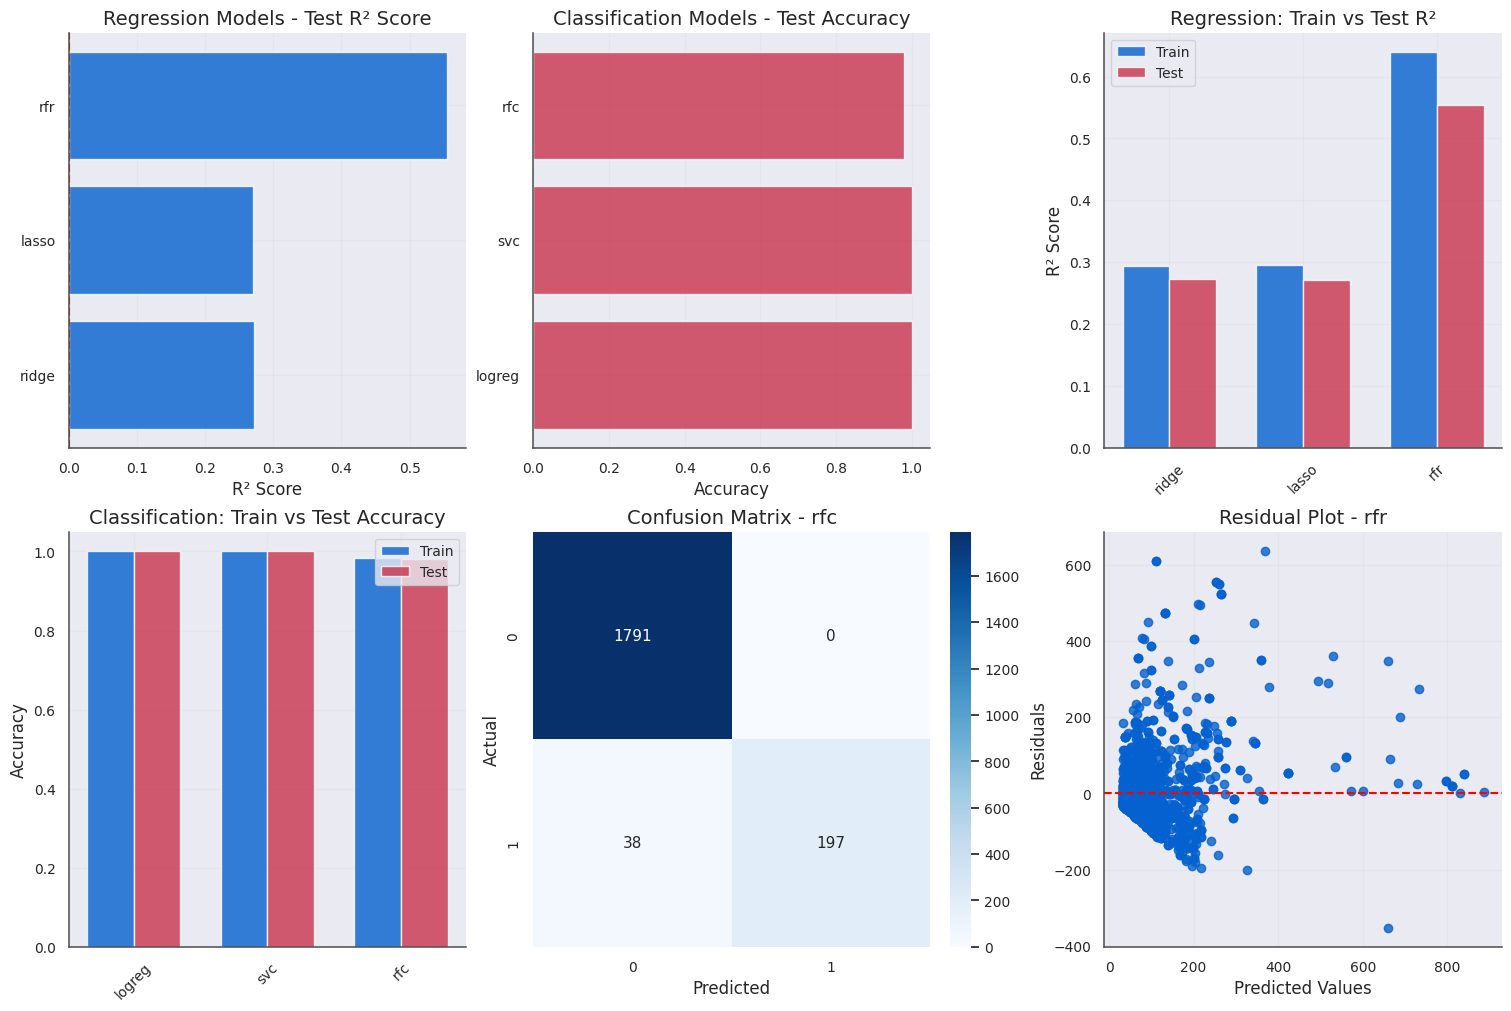

In [37]:
# visualize results
# Plot performance comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
# 1. Regression R² scores
reg_df = results_df[results_df['task'] == 'regression']
axes[0].barh(reg_df['model'], reg_df['test_r2'], color=custom_viz.PALETTE_BLUE[4], alpha=0.8)
axes[0].set_title('Regression Models - Test R² Score')
axes[0].set_xlabel('R² Score')
axes[0].axvline(x=0, color='red', linestyle='--')

# 2. Classification Accuracy
clf_df = results_df[results_df['task'] == 'classification']
axes[1].barh(clf_df['model'], clf_df['test_acc'], color=custom_viz.PALETTE_RED[4], alpha=0.8)
axes[1].set_title('Classification Models - Test Accuracy')
axes[1].set_xlabel('Accuracy')

# 3. Train vs Test comparison (Regression)
x = np.arange(len(reg_df))
width = 0.35
axes[2].bar(x - width/2, reg_df['train_r2'], width, label='Train', color=custom_viz.PALETTE_BLUE[4], alpha=0.8)
axes[2].bar(x + width/2, reg_df['test_r2'], width, label='Test', color=custom_viz.PALETTE_RED[4], alpha=0.8)
axes[2].set_xticks(x)
axes[2].set_xticklabels(reg_df['model'], rotation=45)
axes[2].set_ylabel('R² Score')
axes[2].set_title('Regression: Train vs Test R²')
axes[2].legend()
# axes[2].grid(axis='y', alpha=0.3)
# 4. Train vs Test comparison (Classification)
x = np.arange(len(clf_df))
axes[3].bar(x - width/2, clf_df['train_acc'], width, label='Train', color=custom_viz.PALETTE_BLUE[4], alpha=0.8)
axes[3].bar(x + width/2, clf_df['test_acc'], width, label='Test', color=custom_viz.PALETTE_RED[4], alpha=0.8)
axes[3].set_xticks(x)
axes[3].set_xticklabels(clf_df['model'], rotation=45)
axes[3].set_ylabel('Accuracy')
axes[3].set_title('Classification: Train vs Test Accuracy')
axes[3].legend()
# axes[3].grid(axis='y', alpha=0.3)

# 5. Confusion Matrix for best classifier
if best_clf_model['model'] in conf_matrices:
    cm = conf_matrices[best_clf_model['model']]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[4])
    axes[4].set_title(f"Confusion Matrix - {best_clf_model['model']}")
    axes[4].set_xlabel('Predicted')
    axes[4].set_ylabel('Actual')

# 6. Residual plot for best regressor
if best_reg_model['model'] in best_models:
    best_reg = best_models[best_reg_model['model']]
    y_pred = best_reg.predict(X_test_freight)
    residuals = y_test_freight - y_pred
    
    axes[5].scatter(y_pred, residuals, color=custom_viz.PALETTE_BLUE[4], alpha=0.8)
    axes[5].axhline(y=0, color='red', linestyle='--')
    axes[5].set_title(f"Residual Plot - {best_reg_model['model']}")
    axes[5].set_xlabel('Predicted Values')
    axes[5].set_ylabel('Residuals')
    axes[5].grid(alpha=0.3)

plt.show()

In [61]:
# predict new values
# freight
print("\n" + "="*60)
print("MAKING PREDICTIONS ON NEW DATA")
print("="*60)

# Regression example
new_freight_order = pd.DataFrame({
    'products_unitprice': [25.0],
    'order_details_discount': [0.15],
    'order_details_quantity': [30],
    'productname': ['Chai'],
    'shipcountry': ['USA']
})

best_regressor = best_models[best_reg_model['model']]
predicted_freight = best_regressor.predict(new_freight_order)
print(f"\nFreight Prediction for new order:")
print(f"   Product: Chai, Quantity: 30, Country: USA")
print(f"   Predicted freight: ${predicted_freight[0]:.2f}")


MAKING PREDICTIONS ON NEW DATA

Freight Prediction for new order:
   Product: Chai, Quantity: 30, Country: USA
   Predicted freight: $236.97


In [62]:
# products discontinued
new_product_check = pd.DataFrame({
    'products_unitprice': [45.0],
    'products_units_in_stock': [5],
    'products_reorder_level': [20],
    'productname': ['Chang'],
    'shipcountry': ['Germany']
})

best_classifier = best_models[best_clf_model['model']]
predicted_status = best_classifier.predict(new_product_check)
probability = best_classifier.predict_proba(new_product_check)[0] if hasattr(best_classifier, 'predict_proba') else [0, 0]

print(f"\nDiscontinued Prediction for new product:")
print(f"   Product: Chang, Stock: 5, Reorder Level: 20, Country: Germany")
print(f"   Will be discontinued: {'YES' if predicted_status[0] == 1 else 'NO'}")
if hasattr(best_classifier, 'predict_proba'):
    print(f"   Probability: Active={probability[0]:.2%}, Discontinued={probability[1]:.2%}")


Discontinued Prediction for new product:
   Product: Chang, Stock: 5, Reorder Level: 20, Country: Germany
   Will be discontinued: NO
   Probability: Active=96.74%, Discontinued=3.26%
